<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo02_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [1]:
# Instalação de libs que não estão presentes no Colab
!pip install -q emoji
!pip install -q transformers --no-cache-dir
!pip install -q sentencepiece
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 175 kB 4.2 MB/s 
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 101 kB 64.6 MB/s 
     |████████████████████████████████| 6.6 MB 65.9 MB/s 
     |████████████████████████████████| 1.2 MB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 784 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importação de bibliotecas utilizadas no pré-processamento
import re
import emoji
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pt_core_news_sm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from IPython.display import display

In [13]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 0)
# configura tema dos gráficos
sns.set_theme(style="whitegrid")
#configura a barra de progressos para usar no apply
tqdm.pandas()
# Identifica device gpu ou cpu disponível
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carregar arquivo CSV das bases unificadas e validar

In [ ]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', 
                    sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [ ]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
9341,"Conheçam a futura primeira-dama do Brasil, Michele Bolsonaro! Professora, doutoranda pela USP e fala 3 línguas oficiais, além da língua dos sinais! Simples como o marido , orgulho para as mulheres desse país .👇🏻",1
7716,"Roberto Motta, fundador do Partido Novo, juntamente com João Amoêdo, pede a todos os que iriam votar em Amoêdo que declare agora o seu apoio e voto em Bolsonaro. ISSO É TER RESPONSABILIDADE COM O BRASIL 🇧🇷\nhttps://m.facebook.com/story.php?story_fbid=918070155247857&id=213650655689814",0
8952,*Você recebeu o Desafio da Verdade* - Pesquisa por estado e sem roubalheira. *Vote e Repasse AGORA* | Jair Bolsonaro 89% | Fernando Haddad 11% | 👇👇 https://desafiodaverdade.com,1
9526,*VOU ENCHER O SACO DO GRUPO ATÉ O FIM DO ANO*\n\n *BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA PARA AJUDAR O NOSSO PRESIDENTE ESTÁ AQUI:*\n\nhttps://m.facebook.com/story.php?story_fbid=525897467858283&id=243021376285804,0
8467,"Se o Lula tivesse mesmo tirado o povo da pobreza, não precisaria agora o Ciro Gomes tirá-los do SPC!\n#prontofalei\n🤣😂🤣😂🤣",0


### Exploração e limpeza de dados

In [ ]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', re.sub('(\n|\r)', '', texto))
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Mantem apenas caracteres alfanuméricos com e sem acentuação + pontuação
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = texto.replace('...', '').replace("..", ".").replace(". .", ".")
    # Remove multiplos caracteres em branco
    return re.sub(r'\s+',' ', texto).strip()

dados["texto_processado"] = dados.texto.progress_apply(limpar_textos)
dados["qtde_palavras"] = dados.texto_processado.apply(
                                lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
display(dados[dados['texto'].str.len()<500].sample(n=5)[['classe', 'texto', 'texto_processado']])

,classe,texto,texto_processado
8743,0,"Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, 🙈 acho que não vai ter segundo turno!","Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, acho que não vai ter segundo turno"
8157,0,"Entrevista da candidata Dilma Rousseff ontem (8/09/2018) em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM.","Entrevista da candidata Dilma Rousseff ontem 8092018 em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM."
7655,0,"https://www.oantagonista.com/tv/vazou-propaganda-eleitoral-de-bolsonaro/\n\n\nMuito boa a propaganda eleitoral de Bolsonaro, o video está no antagonista","boa a propaganda eleitoral de Bolsonaro, o video está no antagonista"
7966,0,"Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. \nVejam o vídeo, é de arrepiar com a multidão!","Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. Vejam o vídeo, é de arrepiar com a multidão"
8663,1,"De Lavada !!!!\n\nTracking BTG que acabou de sair para o mercado financeiro:\n👉Bolsonaro 77%;\n👇Haddad 23%.\nPS: Votos válidos.\n\nTemos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as “falsas”pesquisas onde H...","De Lavada Tracking BTG que acabou de sair para o mercado financeiro:Bolsonaro 77Haddad 23.PS: Votos válidos.Temos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as falsaspesquisas onde Haddad já se aproxima de Bo..."


### Carga da spaCy para limpeza de dados

Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)  
Remove stopworks, mas a pontuação é mantida pois é relevante para o modelo.

In [ ]:
nlp = pt_core_news_sm.load()
dados["texto_lematizado"] = dados.texto_processado.progress_apply(
    lambda texto: " ".join([token.lemma_ for token in nlp(texto) 
      if not token.is_stop]))
dados["qtde_lematizado"] = dados.texto_lematizado.apply(
                  lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
display(dados[dados['texto'].str.len()<500].sample(n=10)[['classe', 'qtde_palavras', 'qtde_lematizado', 'texto_processado', 'texto_lematizado']])

### O modelo BERTimbau é sensível ao CASE, precisa ser tratado 

In [ ]:
# Remove linhas com mais de 10% de palavras em maiúsculo
antes = dados.shape[0]
dados['qtde_maiusculas'] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall("[A-Z]+[A-Z]+[A-Z]*[\s]+", texto)))
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_lematizado"])<0.1]
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 9537, depois: 8982, removido: 555'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [ ]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_lematizado'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8982, depois: 8852, removido: 130'

### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras.

In [ ]:
dados_menos_100_palavras = dados[dados["qtde_lematizado"]<100].copy()

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_lematizado'] == coluna_busca]).copy()
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_lematizado.apply(
      lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_lematizado"]<100].texto_lematizado.progress_apply(confere_duplicidade)
dados_menos_100_palavras = pd.DataFrame() #libera área
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_lematizado"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

  0%|          | 0/3461 [00:00<?, ?it/s]

'Qtde linhas antes: 8852, depois: 7905, removido: 947'

## Confere a distribuição de palavras nas classes

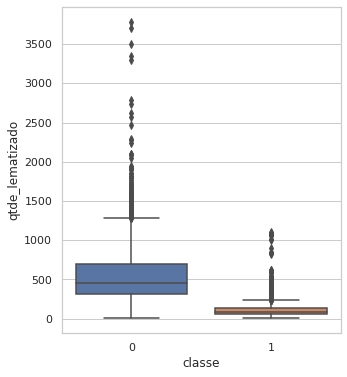

In [ ]:
ax, fig = plt.subplots(figsize=[5,6])
ax = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])

In [ ]:
def grafico_distribuicao(dfplot):
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 2000, 100)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.countplot(x="classe", data=dados)
  axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
  axes2.set_title('Distribuição de classes', fontsize=14)
  axes2.set_ylabel('quantidade')

[0, 1]

[3877, 4028]

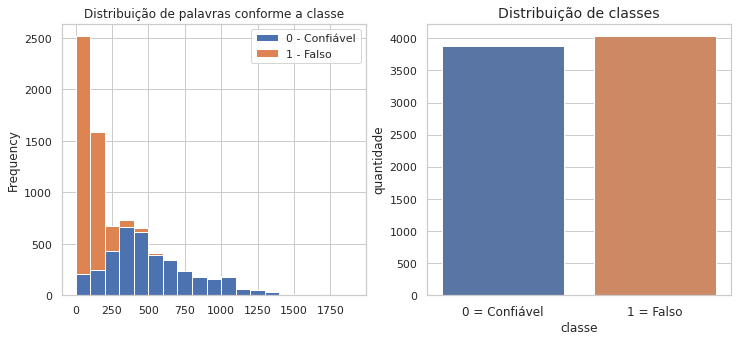

In [ ]:
grafico_distribuicao(dados.pivot(columns='classe').qtde_lematizado)
distribuicao = dados.groupby('classe').qtde_lematizado.count()
display(distribuicao.index.to_list(), distribuicao.to_list())

In [ ]:
antes = dados.shape[0]
dados = dados.query(
    'qtde_lematizado >= 30 and qtde_lematizado <= 2000'
)
display(f"Qtde antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")
display(f"Maximo de palavras: {dados['qtde_lematizado'].max()}", f"Mínimo de palavras: {dados['qtde_lematizado'].min()}")

'Qtde antes: 7905, depois: 7567, removido: 338'

'Maximo de palavras: 1949'

'Mínimo de palavras: 30'

### Carrega o modelo pré-treinado de sumarização

In [ ]:
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(
      device_disponivel
  )

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

### Separação e salvamento do processo parcial antes de rodar o modelo que leva algumas horas

In [ ]:
# Divide o dataframe para executar o modelo somente nos textos grandes e salvar parte do trabalho devido a quedas pela demora
df_menor500, df_maior500 = dados.query('qtde_lematizado <= 500').copy(), dados.query('qtde_lematizado > 500').copy()

# Salva novamente os dados para uso no notebook do próximo passo.
df_menor500.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_menor500.csv', sep = ',', index=False)
df_maior500.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_maior500.csv', sep = ',', index=False)

display(f"Menor: {df_menor500.shape[0]}; Maior: {df_maior500.shape[0]}")

'Menor: 5833; Maior: 1734'

### Principal método que gera os tokens, sumariza e transforma os tokens de volta em palavras

In [ ]:
def resumir_textos(texto):
  input_ids = tokenizer(      # tokeniza o texto
      [texto],
      return_tensors="pt",    # retorna o tensores pytorch
      max_length=2000,        # tamanho máximo de entrada
      truncation=True         # caso exceder, trunca, já limitei
  )["input_ids"]
  t_tokens = input_ids.to(device_disponivel) # envia tokens para GPU
  output_ids = model_pt.generate(   # gera tokens de sumarização
      input_ids=t_tokens,   # tokens de entrada
      max_length=500,       # tamanho máximo
      min_length=200,       # tamanho mínimo (modelo não respeita)
      no_repeat_ngram_size=2, # relação de n-grans que não deve repetir
      length_penalty=1.5,   # penalti por tamanho, maior que 1 para tentar atingir próximo ao max_len
      num_beams=4,          # valor para a fórmula do algoritmo de pesquisa heurística
  )[0]
  resumo = tokenizer.decode(  # decodifica a saída do modelo (converter tokens numéricos para texto)
      output_ids,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False
  )
  return resumo

In [ ]:
df_maior500["texto_resumido"] = df_maior500['texto_lematizado'].progress_apply(resumir_textos)
df_maior500["qtde_lematizado"] = df_maior500.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)

  0%|          | 0/1734 [00:00<?, ?it/s]

In [ ]:
df_maior500.drop("texto_lematizado", axis=1, inplace=True)
df_maior500.rename(columns = {'texto_resumido':'texto_lematizado'}, inplace = True)

dados = pd.concat(
    [df_menor500, df_maior500],
    ignore_index=True,
    copy=True,
)

### Plota novamente para ver como ficou

In [14]:
def grafico_distribuicao_boxplot(dados):
  dfplot = dados.pivot(columns='classe').qtde_lematizado
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 550, 50)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])
  axes2.set_ylabel('Qtde_Palavras')  

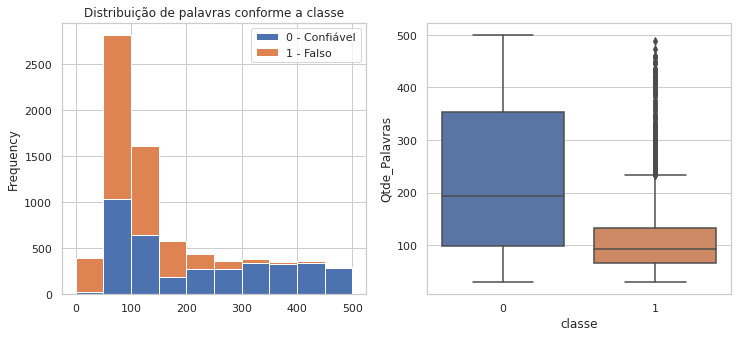

In [15]:
grafico_distribuicao_boxplot(dados)

### Salva resultado para usar na exploração

In [ ]:
# Salva novamente os dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',', index=False)